<a href="https://colab.research.google.com/github/softmurata/fashionML/blob/main/clothrepo/detectron2_with_change_cuda_and_pose_with_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorch Installation

In [ ]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Cuda 11.3 Installation

In [ ]:
!ls -d /usr/local/cuda-*

In [ ]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-ubuntu2004.pin
!sudo mv cuda-ubuntu2004.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/11.3.0/local_installers/cuda-repo-ubuntu2004-11-3-local_11.3.0-465.19.01-1_amd64.deb
!sudo dpkg -i cuda-repo-ubuntu2004-11-3-local_11.3.0-465.19.01-1_amd64.deb
!sudo apt-key add /var/cuda-repo-ubuntu2004-11-3-local/7fa2af80.pub
!sudo apt-get update

In [ ]:
!sudo apt-get -y install cuda-11-3

In [9]:
import os
p = os.getenv('PATH')
ld = os.getenv('LD_LIBRARY_PATH')
os.environ['PATH'] = f"/usr/local/cuda-11.3/bin:{p}"
os.environ['LD_LIBRARY_PATH'] = f"/usr/local/cuda-11.3/lib64:{ld}"

In [13]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:15:46_PDT_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0


In [11]:
import torch
torch.cuda.is_available()

True

Densepose with detectron2

In [1]:
import os
import cv2
import PIL
import glob
import torch
import os.path
import numpy as np
from PIL import Image
from tqdm import tqdm
from shutil import copyfile
from google.colab import files
from IPython.display import clear_output

%cd /content
!rm -rf /content/PWS
!git clone https://github.com/BadourAlBahar/pose-with-style PWS
!mkdir /content/PWS/checkpoints /content/PWS/test_data /content/PWS/result
!pip install -r /content/PWS/requirements.txt
!wget https://filebox.ece.vt.edu/~Badour/pose-with-style/downloads/dp_uv_lookup_256.npy -O /content/PWS/util/dp_uv_lookup_256.npy
!wget https://filebox.ece.vt.edu/~Badour/pose-with-style/downloads/uv_space_parts.npy -O /content/PWS/util/uv_space_parts.npy
!wget https://filebox.ece.vt.edu/~Badour/pose-with-style/pretrained/posewithstyle.pt -O /content/PWS/checkpoints/posewithstyle.pt
!wget https://filebox.ece.vt.edu/~Badour/pose-with-style/downloads/CCM_epoch50.pt -O /content/PWS/checkpoints/CCM_epoch50.pt

%cd /content
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%cd /content
!rm -rf /content/detectron2
!git clone https://github.com/facebookresearch/detectron2.git
!python -m pip install -e detectron2
!pip install av

%cd /content
!rm -rf /content/U-2-Net
!git clone https://github.com/xuebinqin/U-2-Net
%cd /content/U-2-Net
!set -exo
!gdown --id 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
%cd /content

if [len(os.listdir('/content/PWS/checkpoints')) == 2,
    len(os.listdir('/content/PWS/util')) == 8,
    os.path.isfile('/content/U-2-Net/u2net_human_seg.pth')]:
  clear_output()
  print('Done!')

Done!


In [2]:
%cd /content/U-2-Net
try: os.rename('/content/U-2-Net/model', '/content/U-2-Net/model_u2n')
except: pass
from skimage import io, transform
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset
from model_u2n import U2NET # full size version 173.6 MB

def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d-mi)/(ma-mi)
    return dn

def save_output(image_name,pred,d_dir,outline_depth):
    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()
    im = PIL.Image.fromarray(predict_np*255).convert('RGB')
    img_name = image_name.split(os.sep)[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1],image.shape[0]),resample=PIL.Image.BILINEAR)
    pb_np = np.array(imo)
    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]
    image = cv2.cvtColor(np.array(imo), cv2.COLOR_BGR2GRAY)
    if outline_depth != 0:
      contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      cv2.drawContours(image, contours, -1, (255,255,255), outline_depth)
    cv2.imwrite(f'{d_dir}/{imidx}_sil.png',image)

model_dir = '/content/U-2-Net/u2net.pth'
print('downloading 173.6 MB...')
net_u = U2NET(3,1)
if torch.cuda.is_available():
    net_u.load_state_dict(torch.load(model_dir))
    net_u.cuda()
else: net_u.load_state_dict(torch.load(model_dir, map_location='cpu'))
net_u.eval()

%cd /content
clear_output()
print('Done!')

Done!


In [3]:
%%writefile /content/detectron2/projects/DensePose/pickle2png.py
import numpy as np
from PIL import Image
import argparse
import os
import torch

def save_image(image_numpy, image_path):
    image_pil = Image.fromarray(image_numpy.astype(np.uint8))
    image_pil.save(image_path)

parser = argparse.ArgumentParser()
parser.add_argument('--pickle_file', type=str, help="path to pickle file")
parser.add_argument("--save_path", type=str, help="path to save the png images")
args = parser.parse_args()

# READING
f = open(args.pickle_file, 'rb')
data = torch.load(f)
data_size = len(data)
print ('Will process %d images'%data_size)

# save path
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

for img_id in range(data_size):
    # assuming we always have 1 person
    name = data[img_id]['file_name']
    iuv_image_name = name.split('/')[-1].split('.')[0]+ '_iuv.png'
    iuv_name =  os.path.join(args.save_path, iuv_image_name)
    size = np.array(Image.open(name).convert('RGB')).shape
    wrapped_iuv = np.zeros(size)

    print ('Processing %d/%d: %s'%(img_id+1, data_size, iuv_image_name))
    num_instances = len(data[img_id]['scores'])
    if num_instances is 0:
        print ('%s has no person.'%iuv_image_name)
        file_object.write(iuv_image_name+'\n')
    else:
        # get results - process first detected human
        instance_id = 0
        # process highest score detected human
        # instance_id = data[img_id]['scores'].numpy().tolist().index(max(data[img_id]['scores'].numpy().tolist()))
        pred_densepose_result = data[img_id]['pred_densepose'][instance_id]
        bbox_xyxy = data[img_id]['pred_boxes_XYXY'][instance_id]
        i = pred_densepose_result.labels
        uv = pred_densepose_result.uv * 255
        pre_iuv = np.expand_dims(i.cpu(), 0)
        iuv = np.concatenate((pre_iuv, uv.cpu()), axis=0)
        # 3xhxw to hxwx3
        iuv_arr = np.transpose(iuv, (1, 2, 0))
        # wrap iuv to size of image
        wrapped_iuv[int(bbox_xyxy[1]):iuv_arr.shape[0]+int(bbox_xyxy[1]), int(bbox_xyxy[0]):iuv_arr.shape[1]+int(bbox_xyxy[0]), :] = iuv_arr
        save_image(wrapped_iuv, iuv_name)

Writing /content/detectron2/projects/DensePose/pickle2png.py


In [35]:
!rm -rf /content/PWS/test_data/source*
uploaded = files.upload()
for source in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=source, length=len(uploaded[source])))

file_type = source.split('.')[-1]
os.rename(source, '/content/PWS/test_data/source.'+file_type)
source = '/content/PWS/test_data/source.'+file_type

image = cv2.imread(source, cv2.IMREAD_COLOR)
h, w, _ = image.shape
if w > h: image = cv2.resize(image, (512, int((h*512)/w)))
elif h > w: image = cv2.resize(image, (int((w*512)/h), 512))
else: image = cv2.resize(image, (512, 512))
cv2.imwrite('/content/PWS/test_data/source.png', image)

Saving a_source.png to a_source.png
User uploaded file "a_source.png" with length 241402 bytes


True

In [36]:
!rm -rf /content/PWS/test_data/target*
uploaded = files.upload()
for target in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=target, length=len(uploaded[target])))

file_type = target.split('.')[-1]
os.rename(target, '/content/PWS/test_data/target.'+file_type)
target = '/content/PWS/test_data/target.'+file_type

image = cv2.imread(target, cv2.IMREAD_COLOR)
h, w, _ = image.shape
if w > h: image = cv2.resize(image, (512, int((h*512)/w)))
elif h > w: image = cv2.resize(image, (int((w*512)/h), 512))
else: image = cv2.resize(image, (512, 512))
cv2.imwrite('/content/PWS/test_data/target.png', image)

Saving a_col.png to a_col.png
User uploaded file "a_col.png" with length 64639 bytes


True

In [37]:
%cd /content/detectron2/projects/DensePose
data_folder = '/content/PWS/test_data'
!rm -rf /content/dump.pkl
!rm -rf /content/PWS/test_data/.ipynb_checkpoints
!rm -rf /content/PWS/test_data/source_sil.png /content/PWS/test_data/target_sil.png
!rm -rf /content/PWS/test_data/source_iuv.png /content/PWS/test_data/target_iuv.png

images_paths = glob.glob(data_folder + os.sep + '*')

outline_depth = 5 # толщина контура
test_salobj_dataset = SalObjDataset(img_name_list = images_paths, lbl_name_list = [], transform=transforms.Compose([RescaleT(320),ToTensorLab(flag=0)]))
test_salobj_dataloader = DataLoader(test_salobj_dataset, batch_size=1, shuffle=False, num_workers=1)
for i_test, data_test in tqdm(enumerate(test_salobj_dataloader)):
  print('\nStage 1/2\n')
  inputs_test = data_test['image']
  inputs_test = inputs_test.type(torch.FloatTensor)
  inputs_test = Variable(inputs_test.cuda())
  d1,d2,d3,d4,d5,d6,d7= net_u(inputs_test)
  pred = normPRED(d1[:,0,:,:])
  save_output(images_paths[i_test],pred,data_folder,outline_depth)
  del d1,d2,d3,d4,d5,d6,d7
  clear_output()

for i in tqdm(images_paths):
  print(i)
  print('\nStage 2/2\n')
  !python apply_net.py dump configs/densepose_rcnn_R_101_FPN_DL_s1x.yaml \
    https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_101_FPN_DL_s1x/165712116/model_final_844d15.pkl \
    $i --output dump.pkl -v
  !python pickle2png.py \
    --pickle_file dump.pkl \
    --save_path $data_folder


if len(os.listdir('/content/PWS/test_data')) == 6:
  clear_output()
  print('Done!')

Done!


In [ ]:
# inference.py -> 100
"""
utils.save_image(
            output[:, :, :, int(shift):args.size-int(shift)],
            os.path.join(args.save_path, input_name+'_2_'+pose_name+'_vis.png'),
            nrow=1,
            normalize=True,
            value_range=(-1, 1),
        )
"""


# garment_tranfer.py -> 129
"""
utils.save_image(
            output[:, :, :, int(ishift):args.size-int(ishift)],
            os.path.join(args.save_path, input_name+'_and_'+target_name+'_'+args.part+'_vis.png'),
            nrow=1,
            normalize=True,
            value_range=(-1, 1),
        )

utils.save_image(
            part_img[:, :, :, int(ishift):args.size-int(ishift)],
            os.path.join(args.save_path, input_name+'_and_'+target_name+'_'+args.part+'.png'),
            nrow=1,
            normalize=True,
            value_range=(0, 255),
        )
"""

In [ ]:
%cd /content/PWS
!rm -rf /content/PWS/result/*
process_type = "repose" #@param ["repose", "garment_transfer"]
if_garment_transfer_then = "upper_body" #@param ["upper_body", "lower_body", "face"]

if process_type == "repose":
  !CUDA_VISIBLE_DEVICES=0 python inference.py \
    --input_path ./test_data \
    --input_name target \
    --target_name source \
    --CCM_pretrained_model /content/PWS/checkpoints/CCM_epoch50.pt \
    --pretrained_model /content/PWS/checkpoints/posewithstyle.pt \
    --save_path /content/PWS/result
else:
  !CUDA_VISIBLE_DEVICES=0 python garment_transfer.py \
    --input_path ./test_data \
    --input_name source \
    --target_name target \
    --CCM_pretrained_model /content/PWS/checkpoints/CCM_epoch50.pt \
    --pretrained_model /content/PWS/checkpoints/posewithstyle.pt \
    --part $if_garment_transfer_then \
    --save_path /content/PWS/result

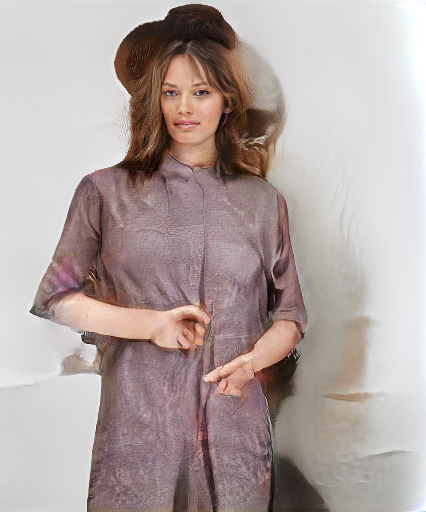

In [39]:
# repose
# wedding dressは無理だった。。上下の服くらいならいけるかも？
# 同じような感じで撮られていないと無理そうかも、ドレスってマジむずい
im = Image.open('/content/PWS/result/target_2_source_vis.png')
im

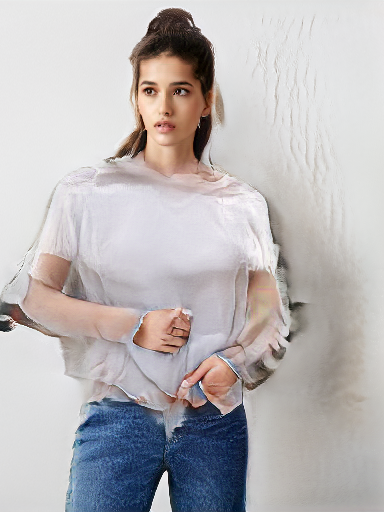

In [28]:
# garment transfer
# ちゃんと服を移し替えるとかそういうのでしか無理そう
display(Image.open('/content/PWS/result/source_and_target_upper_body_vis.png'))